In [1]:
# Simulating dynamics of Argon atoms
# Starting with outlining general kinematics of particles

Week 1:
Play around with this system. Start by simulating the time evolution of a few particles in a periodic box, 
add the forces due to the Lennard-Jones potential. Check how the total energy of your system evolves over time.
It's easier to start with a 2D system, but plan to switch to 3D at a later stage.
Week 2:
Derive the expression of the kinetic energy in dimensionless units
Write a molecular dynamics code that uses dimensionless units and simulate a few atoms. 
Plot both kinetic, potential and total energy.
Boundary condition, minimal image convention

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

In [43]:
def norm(r):
    ''' Calculate the magnitude/norm of a vector r'''
    return np.sqrt(np.sum(r**2.0))

# Acceleration = Force
def acceleration(r):
    '''Force between partices r apart
    r is magnitude (dimensionless)'''
    nablaU = dUdr(norm(r)) * r / norm(r)
    return -nablaU

def apply_boundary_conditions(x):
    '''Apply boundary conditions for a box of size L x L x L to position x'''
    for d in range(3):
        if (x[d] < 0.0):
            x[d] = L - x[d]
        elif (x[d] > L):
            x[d] = x[d] - L
    return x

# velocity at time t
def current_velocity(x_next, x_prev):
    '''Current velocity of a particle
    next position x_next from function at time t+h
    previous position at time t-h'''
    v = (x_next - x_prev)/(2.*h)
    return v

# position at t+h
def next_position(x, v, force):
    '''The next position value
    current position x at time t
    current velocity v
    force from acceleration, at time t
    Dimensionless units'''
    x_next = x + (h*v) + ((h**2.0 /2.0)*(force))
    return apply_boundary_conditions(x_next)

# velocity at time t+h
def next_velocity(v, force, force_next):
    '''Finding the next velocity value
    current velocity time t
    current force time t
    next force time t+h
    Dimensionless units'''
    v_next = v + (h/2)*(force + force_next)
    return v_next

# Potential Energy
def LJP(r):
    '''Lennard-Jones potential formula
    Describes the potential of the system given a distance between two particles
    in dimensionless units, no sigma or epsilon
    function of magnitude distance r'''
    return 4*(1/(r**12.) - 1/(r**6.))

# Kinetic Energy
def KE(v):
    '''Kinetic energy from velocity vector'''
    return 0.5 * v**2.0

def dUdr(r):
    ''' Derivative of LJP WRT r
    in dimensionless units, no sigma or epsilon
    function of magnitude distance r'''
    return -48./(r**13.) + 24/(r**7.)

In [44]:
# Parameters given in dimensionless units of sigma
#  Perhaps convert between units later
# Variables
# Argon
# epsilon = const.k_B * 119.8*u.K
# sigma = 3.405*u.AA
# mass = 39.948*u.u

In [45]:
# The force at x is the negative gradient of the potential at x
# The gradient of the potential is the derivative of the potential WRT r times x/r
# where r is the magnitude of the distance and x is a vector

# Initial conditions
h = 0.05 # time step
num_time = 10  # number of time steps
num_part = 2
L = 10.0       # size of box

x_i_init = np.array([1.0, 9.0, 0.0]) # initial position vector of particle i
v_i_init = np.zeros(3)               # start from rest

x_j_init = np.array([9.0, 1.0, 0.0])
v_j_init = np.zeros(3)

In [46]:
#Test
# next_v = next_velocity(v_init, acc, h)
# print(next_v)
# next_x = next_position(x_init, v_init, h)
# print(next_x)

In [47]:
state = np.zeros((num_part, num_time, 6))  # state consists of 6 degrees of freedom: 3 position coordinates, 3 velocities

# store the initial state of the system
state[0, 0, :3] = x_i_init
state[0, 0, 3:] = v_i_init
state[1, 0, :3] = x_j_init
state[1, 0, 3:] = v_j_init

r_init = state[0, 0, :3] - state[1, 0, :3]
r_init_norm = norm(r_init)

# store the kinetic and potential energy of 2 particles in 3 dimensions for num_time timesteps
E_kin = np.zeros((2, num_time, 3))
E_pot = np.zeros((num_time))
E_tot = np.zeros((num_time))

# store initial kinetic, potential, and total energy of each particle and the system
E_kin[0, 0, :] = KE(v_i_init)
E_kin[1, 0, :] = KE(v_j_init)
E_pot[0] = LJP(r_init_norm)

E_tot[0] = E_pot[t] + E_kin[0, 0, 0] + E_kin[1, 0, 0]

timesteps = range(1, num_time)

# Change in position and velocity
for t in timesteps:
    
    # calculate the distance between the two particles at t-1    
    r = state[0, t-1, :3] - state[1, t-1, :3]
    r_norm = norm(r)
    
    # calculate the force between particles at time t-1
    F = acceleration(r)
    
    # positions at time t
    x_i_next = next_position(r, state[0, t-1, 3:], F)
    x_j_next = next_position(r, state[1, t-1, 3:], F)
    state[0, t, :3] = x_i_next
    state[1, t, :3] = x_j_next
    
    # r and rorce at time t
    r_next = state[0, t, :3] - state[1, t, :3]
    print(r_next)
    r_norm_next = norm(r_next)
    F_next = acceleration(r_next)
    
    # velocity at time t
    v_i_next = next_velocity(state[0, t-1, 3:], F, F_next)
    v_j_next = next_velocity(state[1, t-1, 3:], F, F_next)
    state[0, t, 3:] = v_i_next
    state[1, t, 3:] = v_j_next
    
    # calculate the kinetic energy of the particles
    E_kin[0, t, :] = KE(v_i_next)
    E_kin[1, t, :] = KE(v_j_next)
    
    # calculate the potential energy
    E_pot[t] = LJP(r_norm_next)
    
    # the total energy is the sum of the kinetic energy of both particles and the potential energy
    E_tot[t] = E_pot[t] + norm(E_kin[0, t, :]) + E_kin[1, t, 0]

print(len(E_kin[1]))
print(len(timesteps))
print(range(num_time))

[0. 0. 0.]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
10
9
range(0, 10)


/software/local/lib64/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/software/local/lib64/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/software/local/lib64/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/software/local/lib64/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


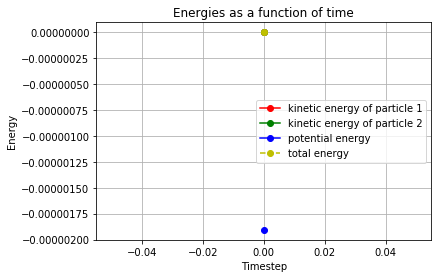

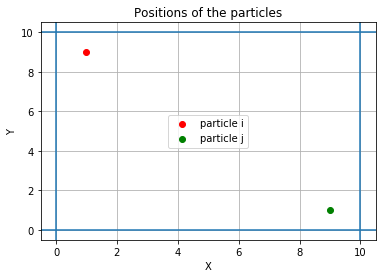

In [39]:
# plot the potential, kinetic and total energy
plt.title('Energies as a function of time')
plt.plot(range(num_time), E_kin[0, :, 0], linestyle='-', marker='o', c='r', label='kinetic energy of particle 1')
plt.plot(range(num_time), E_kin[1, :, 0], linestyle='-', marker='o', c='g', label='kinetic energy of particle 2')
plt.plot(range(num_time), E_pot[:], linestyle='-', marker='o', c='b', label='potential energy')
plt.plot(range(num_time), E_tot[:], linestyle='--', marker='o', c='y', label='total energy')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.grid()
plt.legend()

# plot the positions of both particles in a new figure
plt.figure()
plt.title('Positions of the particles')
plt.scatter(state[0, :, 0], state[0, :, 1], linestyle='-', marker='o', c='r', label='particle i')
plt.scatter(state[1, :, 0], state[1, :, 1], linestyle='-', marker='o', c='g', label='particle j')

# restrict the view around the box + a small margin
view_margin = 0.5
plt.xlim(-view_margin, L + view_margin)
plt.ylim(-view_margin, L + view_margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# add border lines around the box
plt.axvline(0)
plt.axvline(L)
plt.axhline(0)
plt.axhline(L)

plt.show()